In [12]:
import os
import pandas as pd
import re
import csv
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def load_creddata(meta_dir="meta"):
    # Load all metadata CSVs
    meta_files = [f for f in os.listdir(meta_dir) if f.endswith(".csv")]
    df_list = []

    for meta_file in meta_files:
        df = pd.read_csv(os.path.join(meta_dir, meta_file))
        df_list.append(df)

    metadata = pd.concat(df_list, ignore_index=True)

    file_contents = []
    processed_repos = set()
    total_rows = len(metadata)

    for idx, row in metadata.iterrows():
        repo_id = row["RepoName"]
        if repo_id not in processed_repos:
            processed_repos.add(repo_id)
            print(f"Processing repository {len(processed_repos)} / {metadata['RepoName'].nunique()}: {repo_id}")

        data_path = row["FilePath"]
        if not os.path.exists(data_path):
            print(f"Warning: data file for {repo_id} / {row['FileID']} not found, skipping.")
            continue

        try:
            with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read()
        except Exception as e:
            print(f"Error reading {data_path}: {e}")
            continue

        file_contents.append({
            "Id": row["Id"],
            "RepoName": repo_id,
            "FileID": row["FileID"],
            "FilePath": data_path,
            "Content": content,
            "LineStart": row["LineStart"],
            "LineEnd": row["LineEnd"],
            "GroundTruth": row["GroundTruth"],
            "ValueStart": row["ValueStart"],
            "ValueEnd": row["ValueEnd"],
            "Category": row.get("Category", None)
        })

    df = pd.DataFrame(file_contents)

    # Summarize dataset
    total_files = df["FilePath"].nunique()
    total_lines = df["Content"].apply(lambda x: len(x.splitlines())).sum()
    label_counts = df["GroundTruth"].value_counts()

    print("\nDataset Summary")
    print(f"Total repositories processed: {len(processed_repos)}")
    print(f"Total files loaded: {total_files}")
    print(f"Total lines of code: {total_lines}")
    print("GroundTruth counts:")
    print(label_counts)

    return df

In [3]:
df = load_creddata()
print(df.head())

C:\Users\Neha Karne\AppData\Local\Temp\ipykernel_32332\3507358118.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata = pd.concat(df_list, ignore_index=True)


Processing repository 1 / 318: 00408ef6
Processing repository 2 / 318: 0064e882
Processing repository 3 / 318: 02dfa7ec
Processing repository 4 / 318: 0401c075
Processing repository 5 / 318: 0436af4a
Processing repository 6 / 318: 5.357e+91
Processing repository 7 / 318: 057480bf
Processing repository 8 / 318: 06dd1bf2
Processing repository 9 / 318: 7.715e+95
Processing repository 10 / 318: 08295bf0
Processing repository 11 / 318: 0a0d22aa
Processing repository 12 / 318: 0b0a8cd6
Processing repository 13 / 318: 0ce78112
Processing repository 14 / 318: 0de15ccf
Processing repository 15 / 318: 0f133e09
Processing repository 16 / 318: 0fc802c8
Processing repository 17 / 318: 106c7cd2
Processing repository 18 / 318: 110f8d35
Processing repository 19 / 318: 1.1774e+82
Processing repository 20 / 318: 16fc0238
Processing repository 21 / 318: 177cf0f9
Processing repository 22 / 318: 19d43369
Processing repository 23 / 318: 1a2de400
Processing repository 24 / 318: 1ca5e942
Processing repository

In [17]:
def map_groundtruth(df):
    df['Label'] = df['GroundTruth'].map({'F': 0, 'T': 1, 'X': 0})
    return df

# Candidate Extraction with labels
def extract_candidates_with_labels(df, output_file="candidates_with_labels.csv", max_repos=30):
    """
    Extract tokens from files and label them using GroundTruth.
    """
    df = map_groundtruth(df)
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Repo', 'FilePath', 'Line', 'Token', 'Label', 'Category'])

        repos = df['RepoName'].unique()[:max_repos]  # subset of repos

        for repo_index, repo in enumerate(repos, start=1):
            repo_df = df[df['RepoName'] == repo]
            count = 0

            for _, row in repo_df.iterrows():
                content = row['Content']
                line_number = row['LineStart']
                gt_start = row['ValueStart']
                gt_end = row['ValueEnd']
                label = row['Label']
                category = row.get('Category', None)

                # Add GroundTruth secret as a token (positive example)
                if label == 1 and pd.notna(gt_start) and pd.notna(gt_end):
                    secret_token = content[int(gt_start):int(gt_end)]
                    if secret_token.strip():  # skip empty
                        writer.writerow([repo, row['FilePath'], line_number, secret_token, 1, category])
                        count += 1

                # Regex candidates (negative examples)
                candidates = re.findall(r'["\']([^"\']{3,128})["\']', content)
                candidates += re.findall(r'\b[a-zA-Z0-9_]{8,64}\b', content)
                candidates = [t for t in candidates if t.strip() and ' ' not in t]

                for token in candidates:
                    # skip if exactly the secret token already added
                    if label == 1 and pd.notna(gt_start) and pd.notna(gt_end):
                        if token == secret_token:
                            continue
                    writer.writerow([repo, row['FilePath'], line_number, token, 0, category])
                    count += 1

            print(f"[{repo_index}/{len(repos)}] Saved {count} candidates for repo {repo}")

    print("Candidate extraction completed.")

In [18]:
def compute_features(token):
    token = "" if pd.isna(token) else str(token)

    length = len(token)
    num_digits = sum(c.isdigit() for c in token)
    num_upper = sum(c.isupper() for c in token)
    num_lower = sum(c.islower() for c in token)
    num_special = sum(not c.isalnum() for c in token)

    entropy = 0
    if length > 0:
        probs = [token.count(c)/length for c in set(token)]
        entropy = -sum(p * math.log2(p) for p in probs)

    return {
        'length': length,
        'num_digits': num_digits,
        'num_upper': num_upper,
        'num_lower': num_lower,
        'num_special': num_special,
        'entropy': entropy
    }


def build_feature_dataset(candidates_csv="candidates_with_labels.csv",
                          features_csv="training_features.csv"):
    df = pd.read_csv(candidates_csv)
    feature_rows = []

    for _, row in df.iterrows():
        feats = compute_features(row['Token'])
        feats.update({
            'Repo': row['Repo'],
            'FilePath': row['FilePath'],
            'Line': row['Line'],
            'Token': row['Token'],
            'Label': row['Label'],
            'Category': row['Category']
        })
        feature_rows.append(feats)

    features_df = pd.DataFrame(feature_rows)
    features_df.to_csv(features_csv, index=False)
    print(f"Saved ML feature dataset to {features_csv}")
    return features_df

In [7]:
def train_ml_model(features_df, negative_ratio=50, n_estimators=50):
    # Split positives and negatives
    positives = features_df[features_df['Label'] == 1]
    negatives = features_df[features_df['Label'] == 0]

    # Downsample negatives
    if len(negatives) > len(positives) * negative_ratio:
        negatives = negatives.sample(n=len(positives) * negative_ratio, random_state=42)

    balanced_df = pd.concat([positives, negatives]).sample(frac=1, random_state=42)  # shuffle

    # Features and labels
    X = balanced_df[['length','num_digits','num_upper','num_lower','num_special','entropy']]
    y = balanced_df['Label']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Random Forest
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, preds))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    return clf

In [10]:
extract_candidates_with_labels(df, output_file="candidates_with_labels.csv")

[1/30] Saved 195527 candidates for repo 00408ef6
[2/30] Saved 22673 candidates for repo 0064e882
[3/30] Saved 99890 candidates for repo 02dfa7ec
[4/30] Saved 56726 candidates for repo 0401c075
[5/30] Saved 126844 candidates for repo 0436af4a
[6/30] Saved 224 candidates for repo 5.357e+91
[7/30] Saved 10626 candidates for repo 057480bf
[8/30] Saved 205991 candidates for repo 06dd1bf2
[9/30] Saved 17915 candidates for repo 7.715e+95
[10/30] Saved 8548 candidates for repo 08295bf0
[11/30] Saved 3692 candidates for repo 0a0d22aa
[12/30] Saved 259186 candidates for repo 0b0a8cd6
[13/30] Saved 5958 candidates for repo 0ce78112
[14/30] Saved 234615 candidates for repo 0de15ccf
[15/30] Saved 12526523 candidates for repo 0f133e09
[16/30] Saved 22642 candidates for repo 0fc802c8
[17/30] Saved 77459 candidates for repo 106c7cd2
[18/30] Saved 59949 candidates for repo 110f8d35
[19/30] Saved 910 candidates for repo 1.1774e+82
[20/30] Saved 29926 candidates for repo 16fc0238
[21/30] Saved 14460 cand

In [19]:
features_df = build_feature_dataset(candidates_csv="candidates_with_labels.csv",
                                    features_csv="training_features.csv")

Saved ML feature dataset to training_features.csv


In [20]:
model = train_ml_model(features_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4930
           1       0.44      0.75      0.56        99

    accuracy                           0.98      5029
   macro avg       0.72      0.86      0.77      5029
weighted avg       0.98      0.98      0.98      5029

Confusion Matrix:
[[4837   93]
 [  25   74]]


In [14]:
print("===== Dataset Overview =====")
print(f"Total repositories: {df['RepoName'].nunique()}")
print(f"Total files: {df['FilePath'].nunique()}")
print(f"Total lines of code: {df['Content'].apply(lambda x: len(x.splitlines())).sum()}")
print("\nGroundTruth label distribution:")
print(df['GroundTruth'].value_counts())

===== Dataset Overview =====
Total repositories: 318
Total files: 9639
Total lines of code: 224443513

GroundTruth label distribution:
GroundTruth
F    39806
T    13615
X     3859
Name: count, dtype: int64


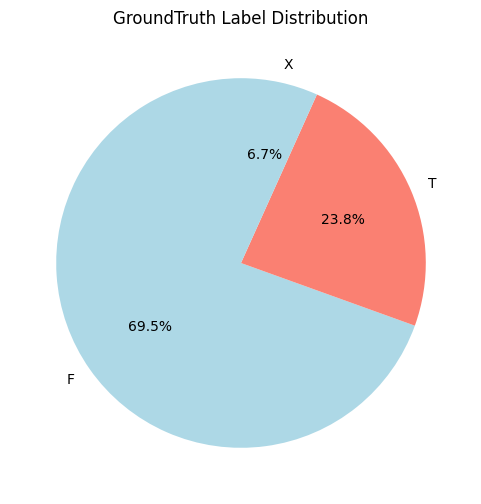

In [8]:
plt.figure(figsize=(6,6))
df['GroundTruth'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue','salmon'])
plt.title("GroundTruth Label Distribution")
plt.ylabel('')
plt.show()

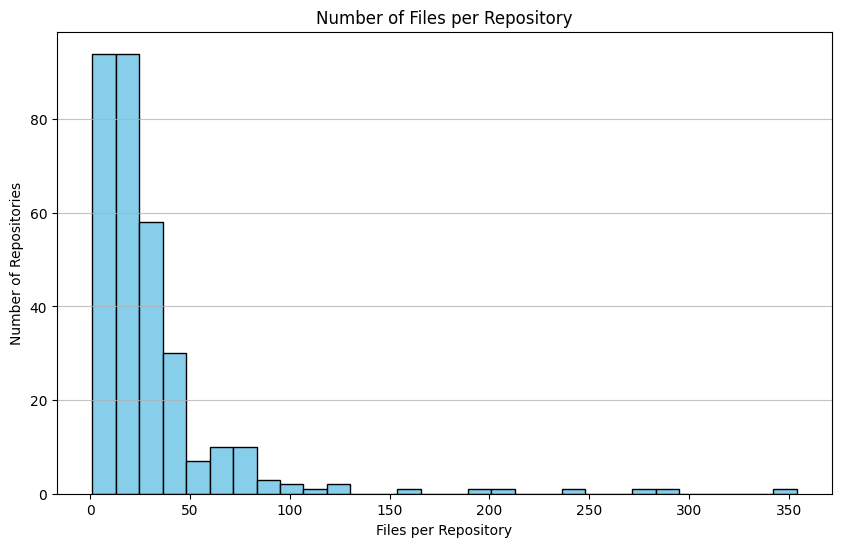

In [9]:
files_per_repo = df.groupby('RepoName')['FilePath'].nunique()

plt.figure(figsize=(10,6))
plt.hist(files_per_repo, bins=30, color='skyblue', edgecolor='black')
plt.title("Number of Files per Repository")
plt.xlabel("Files per Repository")
plt.ylabel("Number of Repositories")
plt.grid(axis='y', alpha=0.75)
plt.show()